In [5]:
import pandas as pd, numpy as np
import matplotlib, seaborn as sns
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams['figure.constrained_layout.use'] = True


In [2]:
mydateparser = lambda x: pd.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
btc_series = pd.read_excel('Data/BTC_closing.xlsx',squeeze=True, parse_dates=[0], index_col=0, date_parser=mydateparser)
btc_df = pd.DataFrame(btc_series)

In [3]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(btc_series)
print('ADF-Statistic: %.4f' %adf_result[0], '\n', adf_result[4])

ADF-Statistic: -1.8142 
 {'1%': -3.4333712566259007, '5%': -2.8628746849930136, '10%': -2.567480519733324}


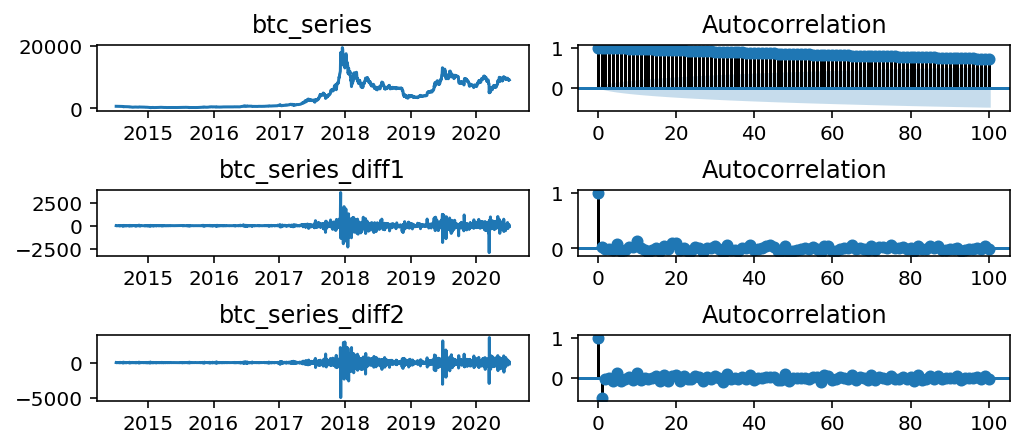

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
#Original series
fig, axes = plt.subplots(3,2)
axes[0,0].plot(btc_series); axes[0,0].set_title('btc_series')
plot_acf(btc_series, ax=axes[0,1], lags=100)

#1st difference
axes[1,0].plot(btc_series.diff().dropna()); axes[1,0].set_title('btc_series_diff1')
plot_acf((btc_series.diff().dropna()), ax=axes[1,1], lags=100)

#2nd difference
axes[2,0].plot(btc_series.diff().diff().dropna()); axes[2,0].set_title('btc_series_diff2')
plot_acf(btc_series.diff().diff().dropna(), ax=axes[2,1], lags=100)

In [13]:
from pmdarima.arima.utils import ndiffs
print('ADF_order:\t', ndiffs(btc_series, test='adf'))
print('PP_order:\t', ndiffs(btc_series, test='pp'))
print('KPSS_order:\t', ndiffs(btc_series, test='kpss'))

ADF_order:	 1
PP_order:	 1
KPSS_order:	 1


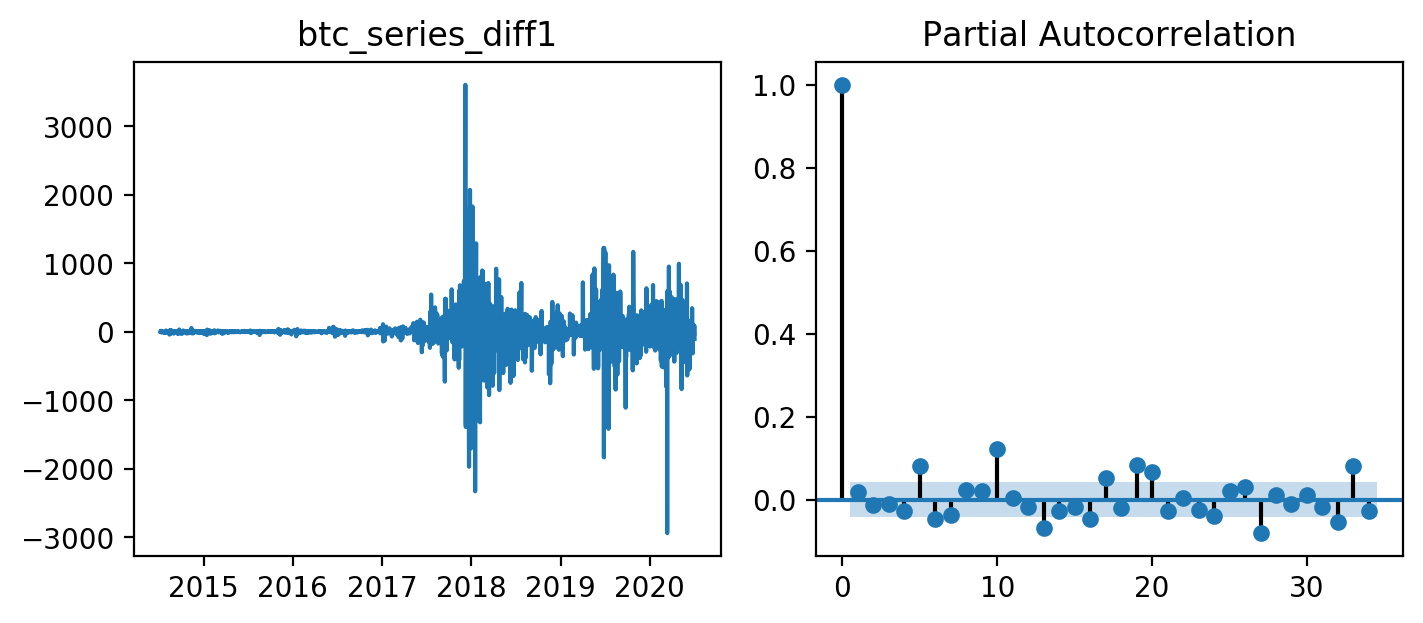

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_series.diff().dropna()); axes[0].set_title('btc_series_diff1')
plot_pacf(btc_series.diff().dropna(), ax=axes[1])

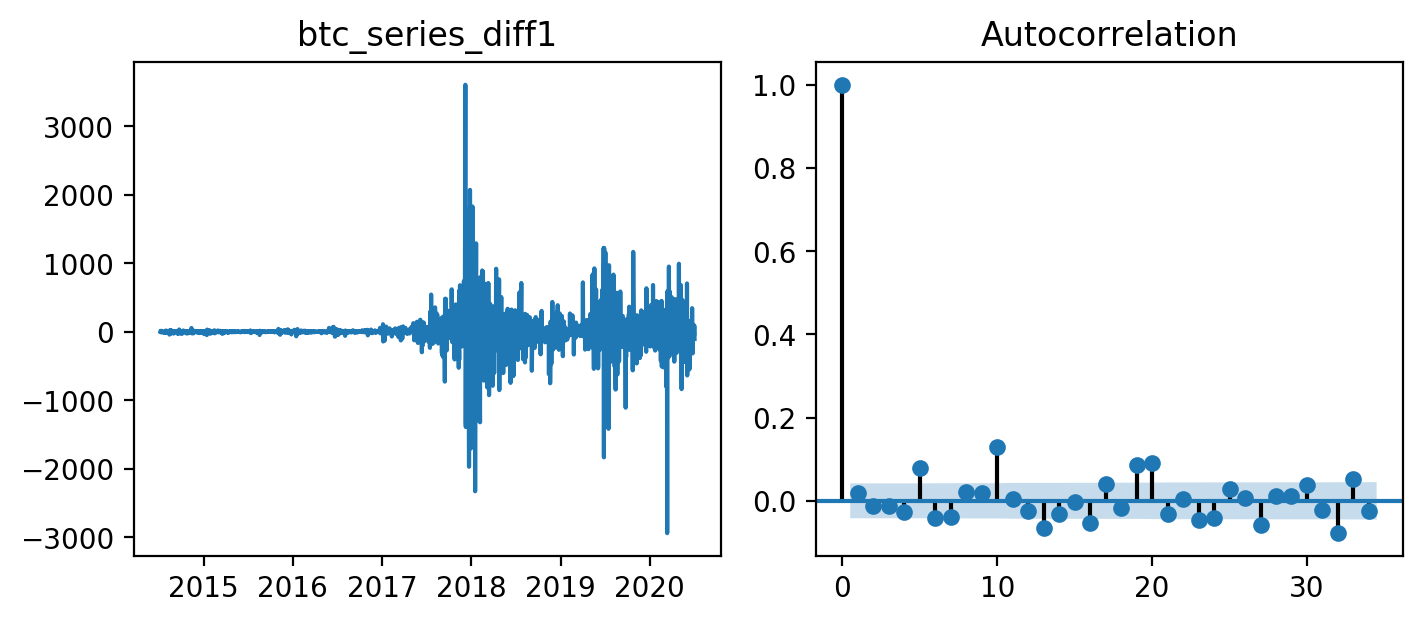

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_series.diff().dropna()); axes[0].set_title('btc_series_diff1')
plot_acf(btc_series.diff().dropna(), ax=axes[1])

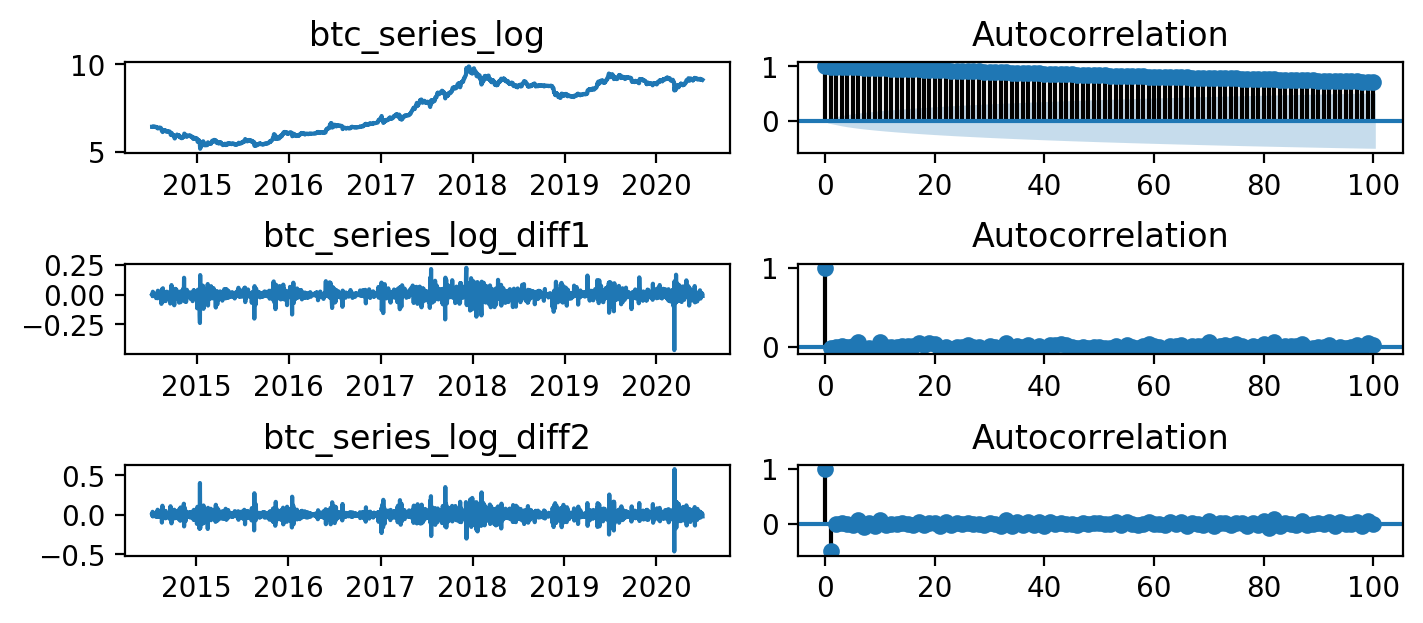

In [37]:
btc_log = np.log(btc_series)

#Original series
fig, axes = plt.subplots(3,2)
axes[0,0].plot(btc_log); axes[0,0].set_title('btc_series_log')
plot_acf(btc_series, ax=axes[0,1], lags=100)

#1st difference
axes[1,0].plot(btc_log.diff().dropna()); axes[1,0].set_title('btc_series_log_diff1')
plot_acf((btc_log.diff().dropna()), ax=axes[1,1], lags=100)

#2nd difference
axes[2,0].plot(btc_log.diff().diff().dropna()); axes[2,0].set_title('btc_series_log_diff2')
plot_acf(btc_log.diff().diff().dropna(), ax=axes[2,1], lags=100)


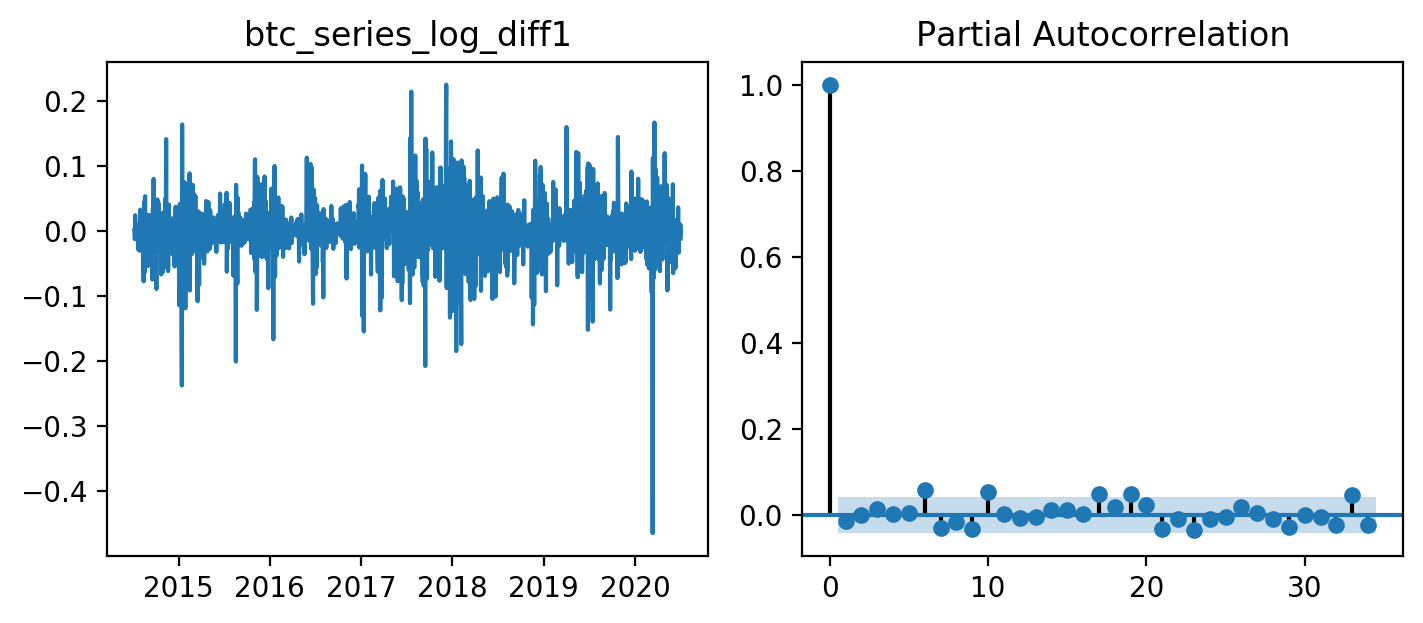

In [38]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_log.diff().dropna()); axes[0].set_title('btc_series_log_diff1')
plot_pacf(btc_log.diff().dropna(), ax=axes[1])

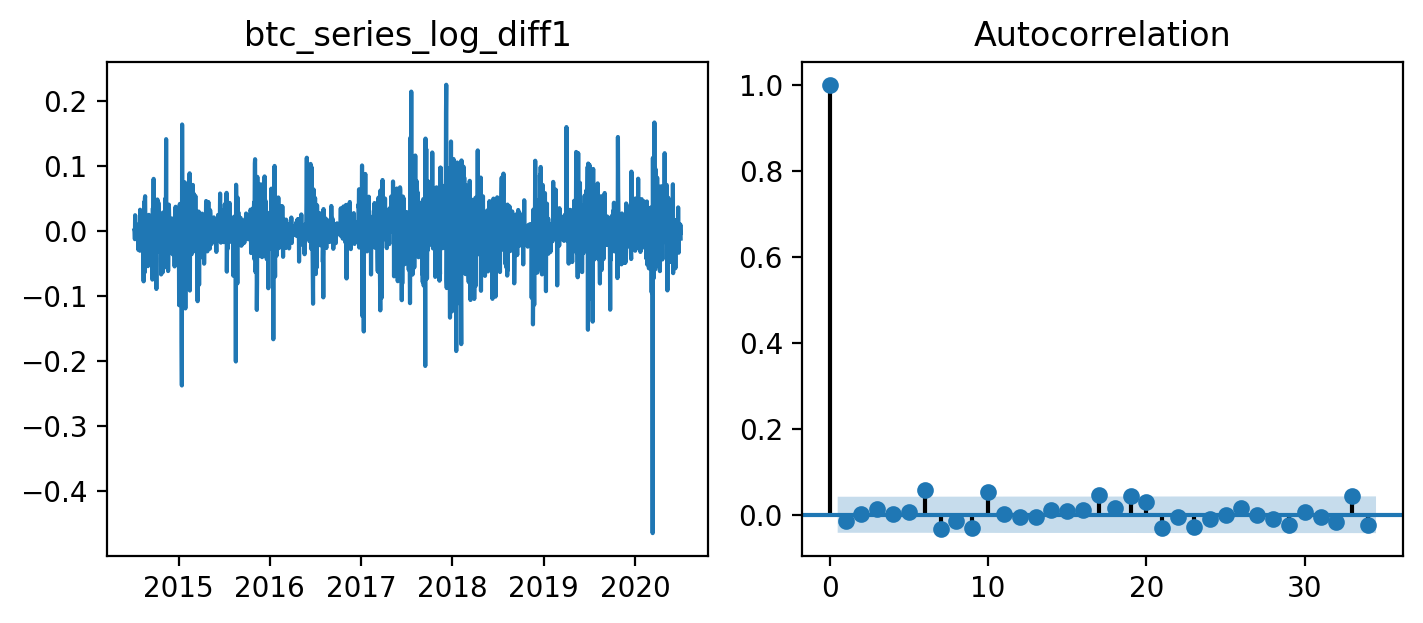

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_log.diff().dropna()); axes[0].set_title('btc_series_log_diff1')
plot_acf(btc_log.diff().dropna(), ax=axes[1])

In [42]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(btc_series, order=(1,1,1))
model_fit = model.fit(disp=0)
model_fit.forecast()


C:\Users\joche\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\joche\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


(array([9122.83372812]),
 array([280.69985337]),
 array([[8572.67212506, 9672.99533119]]))

In [ ]:
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

#evaluate ARIMA model for given arima_order and return rmse
def evaluate_arima_model(data, arima_order):
    train_size = int(len(data) * 0.8)
    train, test = data[0:train_size], data[train_size:]
    history = [x for x in train]
    #make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(btc_series, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0] #no clue here
        predictions.append(yhat)
        history.append(test[t])
    #calculate out of sample error
    mse = mean_squared_error(test.values, predictions)
    rmse = sqrt(mse)
    return rmse

#evaluate p,d,q combinations for ARIMA model
def evaluate_models(data, p_values, d_values, q_values):
    best_score, best_config = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(data, order)
                    if mse < best_score:
                        best_score, best_config = mse, order
                    print('ARIMA%s RMSE = %.4f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s RMSE = %.4f' % (best_config, best_score))

#evalue parameters
p_values = range(0,1)
d_values = range(0,2)
q_values = range(0,1)
warnings.filterwarnings('ignore')
evaluate_models(btc_series, p_values, d_values, q_values)